# Estudo de prioridade de recursos para combate à COVID19 em cidades brasileiras
## Análise de dados do grupo_e 

## Descrição dos pre-requisitos a serem atendidos na análise de dados
Considere o banco de dados covid19 no Brasil (dados do .csv disponibilizado no Moodle);

1. Faça uma análise do desenvolvimento da COVID19 nas 5 cidades definidas pelo grupo de forma a responder as seguintes perguntas:
    - Quais cidades devem ter prioridade na alocação de recursos para o combate à COVID19? 
    - Qual proporção dos recursos cada cidade deve receber? 
    - Qual o nível de risco de cada cidade?
2. O grupo deve justificar as respostas com base nas informações, apresentando e referenciando gráficos dos dados;
3. Os gráficos referentes as 5 cidades devem ser gerados com Python e matplotlib a partir dos dados lidos do banco de dados;
4. Se desejar, o grupo pode fazer um paralelo com dados de outras cidades, de estados e do país sem necessidade de carregar estes dados no BD (i.e. pode carregar DataFrame direto do .csv com Pandas);
5. Entregar em um arquivo.zip todos os arquivos da semana passada (atualizados se necessário), o código e a análise em pdf com imagens dos gráficos (dica: o grupo pode usar Jupyter lab); e
6. O trabalho será avaliado de acordo com a qualidade dos gráficos usados nas justificativas: adequação dos gráficos às justificativas, componentes dos gráficos (títulos, rótulos, legendas) e complexidade dos gráficos. A resposta e justificativa em sí não são avaliadas.

# PostgreSQL - pgAdmin 4 (tarefa inicial)
Conectanto no banco de dados (BD) postgresql e populando as tabelas do BD com as informações do CSV. 

## Programas em Phyton 3 (tarefa 1)
### criador.py

In [ ]:
"""
Conecta no banco de dados postgresql
Cria um banco de dados chamado "covid19_casos_brasil" caso não exista
Cria as tabelas "city" e "cases"
"""

import os

import psycopg2
from psycopg2 import OperationalError, sql
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

DATABASE = 'grupo_e'
USER = 'postgres'
HOST = 'localhost'
PASSWORD = '123'

TABLES = [
    {'name': 'city',
     'sql': 'CREATE TABLE city('
            'city_ibge_code int NOT NULL, '
            'city varchar(255), '
            'state varchar(2), '
            'estimated_population_2019 int, '
            'PRIMARY KEY (city_ibge_code))'},
    {'name': 'cases',
     'sql': 'CREATE TABLE cases('
            'city_ibge_code int NOT NULL,'
            'date date,'
            'epidemiological_week int,'
            'last_available_confirmed int,'
            'last_available_deaths int,'
            'last_available_death_rate numeric,'
            'last_available_confirmed_per_100k_inhabitants numeric,'
            'CONSTRAINT PK_Cases PRIMARY KEY (city_ibge_code, date),'
            'FOREIGN KEY (city_ibge_code) REFERENCES city(city_ibge_code))'}
]


def connect_db():
    """
    Conecta no Banco de dados, se ele não existe cia
    :return: conexão do banco de dados
    """
    try:
        con = psycopg2.connect(
            dbname=DATABASE,
            user=USER,
            host=HOST,
            password=PASSWORD)
    except OperationalError:
        con = psycopg2.connect(
            dbname='postgres',
            user=USER,
            host=HOST,
            password=PASSWORD)
        con.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)  # <-- ADD THIS LINE
        cur = con.cursor()
        cur.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier(DATABASE)))
        con.commmit()
    return con


def check_tables(con):
    """
    Verifica a existência das tabela, se não encontra cria
    :param cur: cursor do Banco
    :return: None
    """

    cur = con.cursor()
    for table in TABLES:
        # Verifica se a tabela existe
        cur.execute("select 1 from information_schema.tables where table_name='{}'".format(table['name']))
        if not cur.fetchone():
            cur.execute(sql.SQL(table['sql']))
    con.commit()
    con.close()


check_tables(connect_db())

### carregador.py

In [ ]:
"""
Popula tabelas do banco de dados com as informações do CSV
"""
import os

import pandas as pd
import psycopg2
from psycopg2 import sql

DATABASE = 'grupo_e'
USER = 'postgres'
HOST = 'localhost'
PASSWORD = '123'

ESTADOS = ['SP', 'ES', 'PR']
CIDADES = ['São Paulo', 'Guarapari', 'Dois Vizinhos', 'Piracicaba', 'Curitiba']

CASOS_COVID19 = pd.read_csv("~/dados/dados_covid.csv")

FILTRO_CIDADES = (CASOS_COVID19['state'].isin(ESTADOS)) & \
                 (CASOS_COVID19['place_type'] == 'city') & \
                 (CASOS_COVID19['city'].isin(CIDADES))

CASOS_COVID19_CIDADES = CASOS_COVID19[FILTRO_CIDADES]

CIDADES = CASOS_COVID19_CIDADES.drop_duplicates(subset=['city']) \
    .set_index('city', drop=False).to_dict(orient='index')
CASOS = CASOS_COVID19_CIDADES.to_dict(orient='index')


def connect_db():
    """
    Conecta no Banco de dados
    :return: Conexão do banco de dados
    """

    con = psycopg2.connect(
        dbname=DATABASE,
        user=USER,
        host=HOST,
        password=PASSWORD)
    return con


def create_cidade(con, cidade):
    """
    Verifica se a cidade já existe, se não existe cria
    :param cur_db: Conexão para o banco de dados
    :param cidade: Dados da cidade
    :return: None
    """
    cur = con.cursor()
    cur.execute("""SELECT 1 FROM city WHERE city_ibge_code = '{}'"""
                .format(int(cidade['city_ibge_code'])))
    cidade_existe = cur.fetchone()

    if not cidade_existe:
        cur.execute("""INSERT INTO city(
        city_ibge_code, 
        city, 
        state, 
        estimated_population_2019) VALUES('{}','{}','{}','{}');"""
                    .format(int(cidade['city_ibge_code']),
                            cidade['city'],
                            cidade['state'],
                            int(cidade['estimated_population_2019'])))
        con.commit()


def create_caso(con, caso):
    """
    Verifica se já existe o caso no banco de dados, se não existir salva
    :param cur_db: Conexão para o banco de dados
    :param caso: Dados do caso
    :return: None
    """

    cur = con.cursor()
    cur.execute("""SELECT 1 FROM cases WHERE city_ibge_code = '{}' AND date = '{}'"""
                .format(int(caso['city_ibge_code']), caso['date']))
    caso_existe = cur.fetchone()

    if not caso_existe:
        cur.execute(sql.SQL("""INSERT INTO cases(
            city_ibge_code, 
            date, 
            epidemiological_week, 
            last_available_confirmed,
            last_available_deaths,
            last_available_death_rate,
            last_available_confirmed_per_100k_inhabitants) VALUES('{}','{}','{}','{}','{}','{}','{}');""".format(
            int(caso['city_ibge_code']),
            caso['date'],
            int(caso['epidemiological_week']),
            int(caso['last_available_confirmed']),
            int(caso['last_available_deaths']),
            float(caso['last_available_death_rate']),
            round(float(caso['last_available_confirmed_per_100k_inhabitants']), 5))))
        con.commit()


if __name__ == '__main__':
    con = connect_db()

    for cidade in CIDADES:
        create_cidade(con, CIDADES[cidade])

    for caso in CASOS:
        create_caso(con, CASOS[caso])

## Importando o banco de dados do PostgesSQL para Phyton 3 


### Programas para importação e análise gráfica em  Phyton 3  (tarefa 2)

### analisador.py

In [369]:
"""
Executa queries no banco de dados e plota gráficos
"""
import pandas as pd
import psycopg2
from psycopg2 import sql
import matplotlib.pyplot as plt


DATABASE = 'grupo_e'
USER = 'postgres'
HOST = 'localhost'
PASSWORD = '123'


def connect_db():
    """
    Conecta no Banco de dados
    :return: Conexão do banco de dados
    """

    con = psycopg2.connect(
        dbname=DATABASE,
        user=USER,
        host=HOST,
        password=PASSWORD)
    return con


def search(query):
    db = connect_db()
    cur = db.cursor()
    cur.execute(sql.SQL(query))
    return cur.fetchall()


def plot_test():
    query = "SELECT * FROM city AS cidade INNER JOIN cases AS casos USING (city_ibge_code) ORDER BY date ASC;" #trocar o nome da query para consultas
    response = search(query)
    dataframe = pd.DataFrame(response)
    return dataframe


if __name__ == "__main__":
    dataframe = plot_test()
    pass

In [370]:
dataframe.head(2)

,0,1,2,3,4,5,6,7,8,9
0,3550308,São Paulo,SP,12252023,2020-02-25,9,1,0,0.0,0.00816
1,3550308,São Paulo,SP,12252023,2020-02-26,9,1,0,0.0,0.00816


In [371]:
dataframe.tail(2)

,0,1,2,3,4,5,6,7,8,9
558,3538709,Piracicaba,SP,404142,2020-07-12,29,3872,119,0.0307,958.07909
559,3550308,São Paulo,SP,12252023,2020-07-12,29,151365,8176,0.054000000000000006,1235.42863


### analisador_sqlalchemy.py

In [ ]:
"""
Executa queries no banco de dados e plota gráficos
"""
import matplotlib.pyplot as plt
from psycopg2 import sql
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from grupoe.models import City
import pandas as pd

DATABASE = 'grupo_e'
USER = 'postgres'
HOST = 'localhost'
PASSWORD = '123'


def connect_db():
    """
    Conecta no Banco de dados
    :return: Conexão do banco de dados
    """

    engine = create_engine(f'postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}/{DATABASE}')
    Session = sessionmaker(bind=engine)
    session = Session()
    return session


def plot_test():
    session = connect_db()
    cities = session.query(City.city, City.city_ibge_code).filter(City.city_ibge_code==3550308).all()
    cities_df = pd.DataFrame(cities)

    return cities_df


if __name__ == "__main__":
    cities_df = plot_test()

### models.py

In [ ]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, ForeignKey, Numeric
from sqlalchemy.orm import relationship

Base = declarative_base()


class City(Base):
    __tablename__ = 'city'

    city_ibge_code = Column(Integer, primary_key=True)
    city = Column(String)
    state = Column(String)
    estimated_population_2019 = Column(Integer)

    def __repr__(self):
        return f'City {self.city}'


class Cases(Base):
    __tablename__ = 'cases'

    city_ibge_code = Column(Integer,
           ForeignKey('city.city_ibge_code', ondelete="SET NULL"),
           index=True, primary_key=True)
    city_ibge = relationship(City)

    date = Column(String, primary_key=True)
    epidemiological_week = Column(Integer)
    last_available_confirmed = Column(Integer)
    last_available_deaths = Column(Integer)
    last_available_death_rate = Column(Numeric)
    last_available_confirmed_per_100k_inhabitants = Column(Numeric)

    def __repr__(self):
        return f'IBGE {self.city_ibge_code}, Date {self.date}'

### Importando com script [simples]

A vantagem desse código é que não se perde o rótulo das colunas.

In [372]:
import psycopg2 as pg
import pandas.io.sql as psql
conn = pg.connect("host=localhost dbname=grupo_e user=postgres password=123")
grupo_e = psql.read_sql("SELECT * FROM city AS cidade INNER JOIN cases AS casos USING (city_ibge_code) ORDER BY date ASC;", conn)

In [373]:
grupo_e.head(2) 

,city_ibge_code,city,state,estimated_population_2019,date,epidemiological_week,last_available_confirmed,last_available_deaths,last_available_death_rate,last_available_confirmed_per_100k_inhabitants
0,3550308,São Paulo,SP,12252023,2020-02-25,9,1,0,0.0,0.00816
1,3550308,São Paulo,SP,12252023,2020-02-26,9,1,0,0.0,0.00816


In [374]:
grupo_e.tail(2)

,city_ibge_code,city,state,estimated_population_2019,date,epidemiological_week,last_available_confirmed,last_available_deaths,last_available_death_rate,last_available_confirmed_per_100k_inhabitants
558,3538709,Piracicaba,SP,404142,2020-07-12,29,3872,119,0.0307,958.07909
559,3550308,São Paulo,SP,12252023,2020-07-12,29,151365,8176,0.0540,1235.42863


# Graficando: de dados à informação

Para uma leitura de tendências utilizou-se gráficos de linhas, enquanto que para avaliar frequências o de barras. 

As cidades brasileiras deste caso de estudo são: **Curitiba-PR**, **Dois Vizinhos-PR**, **Guarapari-ES**, **Piracicaba-SP** e **São Paulo-SP**.

As questões norteadoras desta análise foram:
- Quais cidades devem ter prioridade na alocação de recursos para o combate à COVID19?
- Qual o nível de risco de cada cidade?
- Qual proporção dos recursos cada cidade deve receber?

Para isto serão consideradas as variáveis respostas:
- Número de casos confirmados de COVID-19 nas cidades deste caso de estudo (last_available_confirmed);
- Taxa de mortalidade (last_available_death_rate);
- Tamanho populacional em 2019 (estimated_population_2019); e
- Avaliação da última semana informada (12/07/2020), com: 
    - Número de casos de COVID-19 confirmados (last_available_confirmed);
    - Número de mortes por COVID-19 (last_available_deaths); e
    - Porcentagem de Mortalidade, obtida a partir da expressão: 
    
$$\mbox{Mortalidade (%)} = 100 * (\mbox{Número de mortes por COVID-19 }  /  \mbox{ Número de casos de COVID-19 confirmados})$$

Também foram consideradas algumas estattíticas descritivas de cada cidade no período informado, de 25/02/2020 a 12/07/2020. 

A seguir são geradas informações gráficas e estatísticas descritivas para a tomada de decisão.

In [498]:
#carregando bibliotecas/pacotes
import matplotlib.pyplot as plt
import math
import numpy as np

## Número de casos confirmados de COVID-19 nas cinco cidades


In [499]:
# manipulando os dados
##renomeando rótulos de colunas para facilitar legendas e nomenclaturas de eixos
grupo_e.rename(columns = {'date': 'Data', 'city': 'Cidade'}, inplace=True)
grupo_e.tail(2)

,city_ibge_code,Cidade,state,estimated_population_2019,Data,epidemiological_week,last_available_confirmed,last_available_deaths,last_available_death_rate,last_available_confirmed_per_100k_inhabitants
558,3538709,Piracicaba,SP,404142,2020-07-12,29,3872,119,0.0307,958.07909
559,3550308,São Paulo,SP,12252023,2020-07-12,29,151365,8176,0.0540,1235.42863


In [500]:
## variável resposta: last_available_confirmed <- casos_confirmados <- cc
df_cc = grupo_e.pivot_table(index='Data', columns='Cidade', values='last_available_confirmed')
df_cc = df_cc.fillna(0) # preenchendo os NA's com o valor 0 (zero)
df_cc.tail(2)

Cidade,Curitiba,Dois Vizinhos,Guarapari,Piracicaba,São Paulo
Data,,,,,
2020-07-11,8431.0,17.0,1312.0,3872.0,151365.0
2020-07-12,8431.0,17.0,1324.0,3872.0,151365.0


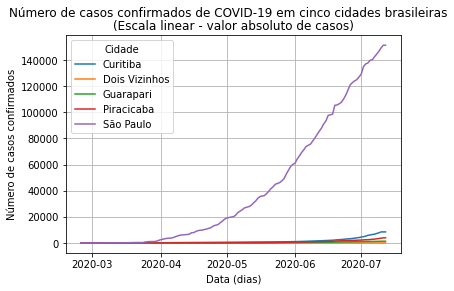

In [501]:
##graficando cc
### escala linear 
df_cc.plot()
plt.suptitle('Número de casos confirmados de COVID-19 em cinco cidades brasileiras')
plt.title('(Escala linear - valor absoluto de casos)')
plt.ylabel('Número de casos confirmados')
plt.xlabel('Data (dias)')
plt.grid(True)
plt.show() #mostrando gráfico

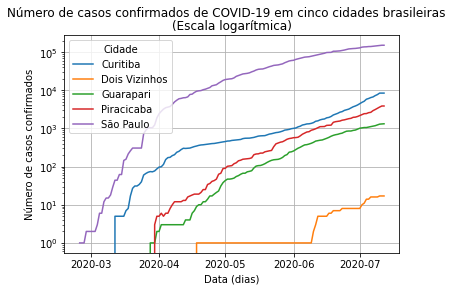

In [502]:
##graficando cc
### escala logarítmica    
df_cc.plot()
plt.yscale('log') #escala logarítmica
plt.suptitle('Número de casos confirmados de COVID-19 em cinco cidades brasileiras')
plt.title('(Escala logarítmica)')
plt.ylabel('Número de casos confirmados')
plt.xlabel('Data (dias)')
plt.grid(True)
plt.show() 

## Taxa de mortalidade

In [503]:
## variável resposta: last_available_death_rate <- dr
df_dr = grupo_e.pivot_table(index='Data', columns='Cidade', values='last_available_death_rate')
df_dr = df_cc.fillna(0) # preenchendo os NA's com o valor 0 (zero)
#df_dr.tail(2)

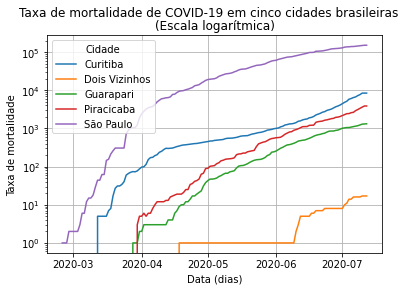

In [504]:
##graficando dr
df_dr.plot()
plt.yscale('log') #escala logarítmica
plt.suptitle('Taxa de mortalidade de COVID-19 em cinco cidades brasileiras')
plt.title('(Escala logarítmica)')
plt.ylabel('Taxa de mortalidade')
plt.xlabel('Data (dias)')
plt.grid(True)
plt.show() 

## Avaliação da última semana informada (12/07/2020)
Variáveis respostas: número de habitantes/cidade em 2019 e número de casos, número de mortes e taxa de mortalidade por COVID-19.

In [505]:
#Manipulação de dados: avaliação sa última data informada

##filtrando a ultima semana
df_1207 = grupo_e[grupo_e['epidemiological_week']==29] 
df_1207.head()

,city_ibge_code,Cidade,state,estimated_population_2019,Data,epidemiological_week,last_available_confirmed,last_available_deaths,last_available_death_rate,last_available_confirmed_per_100k_inhabitants
555,3202405,Guarapari,ES,124859,2020-07-12,29,1324,64,0.0483,1060.39613
556,4106902,Curitiba,PR,1933105,2020-07-12,29,8431,210,0.0249,436.13772
557,4107207,Dois Vizinhos,PR,40641,2020-07-12,29,17,0,0.0000,41.82968
558,3538709,Piracicaba,SP,404142,2020-07-12,29,3872,119,0.0307,958.07909
559,3550308,São Paulo,SP,12252023,2020-07-12,29,151365,8176,0.0540,1235.42863


### Tamanho populacional em 2019 e dados de COVID-19 em 12/07/2020

In [536]:
##renomeando rótulos de colunas para facilitar legendas e nomenclaturas de eixos
df_1207.rename(columns = {'estimated_population_2019': 'Tamanho populacional em 2019', 'last_available_confirmed': 'Número de casos de COVID-19 confirmados', 'last_available_deaths': 'Número de mortes por COVID-19'}, inplace=True)

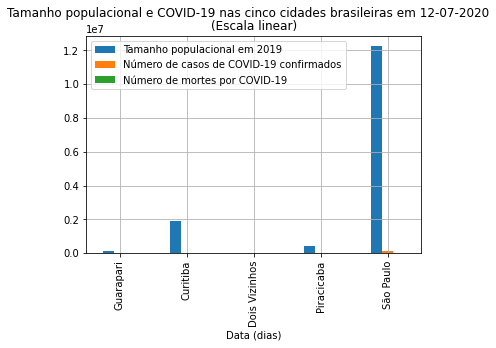

In [532]:
#graficando
df_1207.plot.bar('Cidade', ['Tamanho populacional em 2019', 'Número de casos de COVID-19 confirmados', 'Número de mortes por COVID-19'])
plt.suptitle('Tamanho populacional e COVID-19 nas cinco cidades brasileiras em 12-07-2020')
plt.title('(Escala linear)')
plt.xlabel('Data (dias)')
plt.grid(True)
plt.legend(loc='best') #localiza o melhor local para inserir legenda
plt.show() 

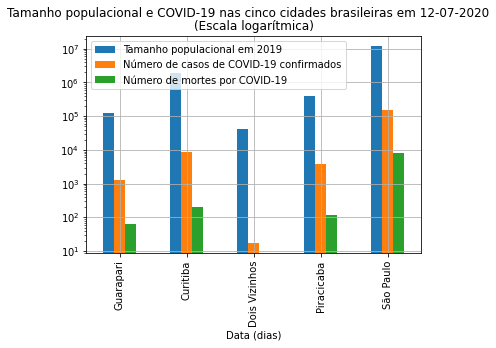

In [520]:
#graficando
df_1207.plot.bar('Cidade', ['Tamanho populacional em 2019', 'Número de casos de COVID-19 confirmados', 'Número de mortes por COVID-19'])
plt.yscale('log') #escala logarítmica
plt.suptitle('Tamanho populacional e COVID-19 nas cinco cidades brasileiras em 12-07-2020')
plt.title('(Escala logarítmica)')
plt.xlabel('Data (dias)')
plt.grid(True)
plt.legend(loc='best') #localiza o melhor local para inserir legenda
plt.show() 

### Mortalidade (%)

In [537]:
df_1207['Mortalidade (%)'] = 100*df_1207['Número de mortes por COVID-19']/df_1207['Número de casos de COVID-19 confirmados']

/home/lilica/meu_projeto/meu_projeto_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


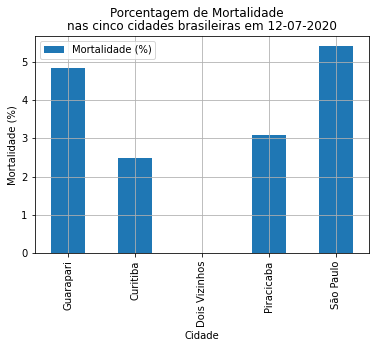

In [538]:
#graficando
df_1207.plot.bar('Cidade', 'Mortalidade (%)')
plt.suptitle('Porcentagem de Mortalidade')
plt.title('nas cinco cidades brasileiras em 12-07-2020')
plt.xlabel('Cidade')
plt.ylabel('Mortalidade (%)')
plt.grid(True)
plt.show() 

## Estatísticas descritivas de cada cidade em estudo 
Período avaliado: de 25/02/2020 a 12/07/2020.
Variáveis respostas: número de casos de COVID-19 confirmados (last_available_confirmed) e 
número de mortes por COVID-19 (last_available_deaths). 

In [539]:
#sumarizando a informação da última semana avaliada/informada no dataframe
##describe()
#filtrando por cidade 

#CURITIBA
df_ct = grupo_e[grupo_e['Cidade'] == 'Curitiba'] 
df_ct[['last_available_confirmed','last_available_deaths']].describe()

,last_available_confirmed,last_available_deaths
count,123.000000,123.000000
mean,1406.658537,49.731707
std,1991.830400,57.920957
min,5.000000,0.000000
25%,289.000000,5.500000
50%,557.000000,29.000000
75%,1560.000000,71.000000
max,8431.000000,210.000000


In [528]:
#DOIS VIZINHOS
df_dv = grupo_e[grupo_e['Cidade'] == 'Dois Vizinhos'] 
df_dv[['last_available_confirmed','last_available_deaths']].describe()

,last_available_confirmed,last_available_deaths
count,86.000000,86.0
mean,4.174419,0.0
std,4.899440,0.0
min,1.000000,0.0
25%,1.000000,0.0
50%,1.000000,0.0
75%,7.000000,0.0
max,17.000000,0.0


In [529]:
#GUARAPARI
df_gua = grupo_e[grupo_e['Cidade'] == 'Guarapari'] 
df_gua[['last_available_confirmed','last_available_deaths']].describe()

,last_available_confirmed,last_available_deaths
count,107.000000,107.000000
mean,327.056075,14.214953
std,394.872486,17.443184
min,1.000000,0.000000
25%,15.500000,0.000000
50%,129.000000,5.000000
75%,537.500000,23.500000
max,1324.000000,64.000000


In [530]:
#PIRACICABA
df_pira = grupo_e[grupo_e['Cidade'] == 'Piracicaba'] 
df_pira[['last_available_confirmed','last_available_deaths']].describe()

,last_available_confirmed,last_available_deaths
count,105.000000,105.000000
mean,772.761905,32.961905
std,983.086393,34.774804
min,3.000000,0.000000
25%,41.000000,4.000000
50%,259.000000,19.000000
75%,1204.000000,52.000000
max,3872.000000,119.000000


In [531]:
#SÃO PAULO
df_sp = grupo_e[grupo_e['Cidade'] == 'São Paulo'] 
df_sp[['last_available_confirmed','last_available_deaths']].describe()

,last_available_confirmed,last_available_deaths
count,139.000000,139.000000
mean,42563.676259,2692.438849
std,48024.688981,2730.384228
min,1.000000,0.000000
25%,1559.000000,112.000000
50%,20073.000000,1683.000000
75%,75247.500000,4928.500000
max,151365.000000,8176.000000


# Considerações finais

Para tomada de decisão quanto a prioridade de alocação de recursos para os municípios 
brasileiros procurou-se investigar, a partir de algumas variáveis respostas pertecentes ao banco de dados, e gerar informações relacionados a:

- **Nível de risco**: considerou-se que é mais alto onde os valores estão crescendo e mais baixo onde estão caindo, a partir das variáveis respostas na **série temporal** de  25/02/2020 a 12/07/2020:
    - número de casos confirmados de COVID-19;
    - taxa de mortalidade em valor absoluto. 
    
- **Proporção dos recursos**: que poderá ser computado em termos do cálculo de custo em reais/vítima visando alocação de recursos para as cidades, para isto pode ser levado em conta: 
    - o tamanho populacional em 2019;
    - a avaliação da última semana informada (12/07/2020), com foco em: (i) no número de casos de COVID-19 confirmados; (ii) número de mortes por COVID-19 e (iii) taxa de mortalidade em percentual.

O estudo da variável resposta "número de casos confirmados de COVID-19" se deu via gráficos de linha nas escalas linear e logarítmica. 
Isto porque, na escala linear, a distância entre as marcas no eixo equivale ao mesmo valor absoluto. Já na escala logarítmica, a distância entre as marcas no eixo equivale à mesma proporção, sendo útil quando a amplitude dos dados é muito grande por facilitar a leitura das variações. 
Desta forma, foi possível observar que os municípios com maiores valores foram: 
São Paulo-SP, Curitiba-PR, Piracicaba-SP, Guarapari-ES e Dois Vizinhos-PR, respectivamente. 

Para a variável resposta "taxa de mortalidade", foi plotado o gráfico intitulado "Taxa de mortalidade de COVID-19 em cinco cidades brasileiras", na escala logarítmica. O resultado foi o mesmo da da variável resposta "número de casos confirmados de COVID-19", i.e.: São Paulo-SP, Curitiba-PR, Piracicaba-SP, Guarapari-ES e Dois Vizinhos-PR, respectivamente.

Agora considerando o tamanho populacional em 2019, na escala logarítimica no gráfico de barras, intitulado "Tamanho populacional e COVID-19 nas cinco cidades brasileiras em 12-07-2020", verifica-se o seguinte ranqueamento: as capitais (São Paulo-SP, Curitiba-PR) se destacam em relação as cidades no interior dos estados (Piracicaba-SP, Guarapari-ES e Dois Vizinhos-PR, respectivamente) em número de habitantes.

Porém, em relação a porcentagem de mortalidade em 12-07-2020 destaca-se a cidade de São Paulo-SP, seguida por Guarapari-ES, Piracicaba-SP, Curitiba-PR e Dois Vizinhos-PR, respecivamente.  
Possívelmente, Guarapari-ES tem menor possibilidade de assistência médica-hospitalar quando comparada à Curitiba-PR e Piracicaba-SP, que têm maior tamanho populacional. 



Para a definição de **prioridade de recursos** também poderia se levar em conta a estrutura hospitalar das cidades. Por exemplo, considerando o mesmo número de habitantes, cidades que não possuem leitos provavelmente precisarão de mais recursos (e.g. equipamentos e insumos para atendimentos emergenciais, assim como, transporte de pacientes) do que àquelas que já os têm. O Ministério da Saúde disponibiliza dados de leitos no Brasil em: <https://viz.saude.gov.br/extensions/DEMAS_C19Insumos_LEITOS/DEMAS_C19Insumos_LEITOS.html>. 

Ademais, e de acordo com o IBGE (Instituto Brasileiro de Geografia e Estatística), para investigar a **prioridade de recursos** poderiam ser consideras as **regiões geográficas imediatas** -- agrupamentos de municípios que têm como principal referência a conexão de cidades próximas através de relações de dependência e deslocamento da população em busca de bens, prestação de serviços e trabalho -- e **regiões intermediárias** -- agrupamentos de regiões imediatas que são articuladas através da influência de uma metrópole, capital regional ou centro urbano representativo dentro do conjunto. O banco de dados do IBGE na plataforma SIDRA (Sistema IBGE de Recuperação Automática) poderiam auxiliar na gestão de recursos, em particular com uso de: os dados de "Estimativas de População", disponível em: <https://sidra.ibge.gov.br/pesquisa/estimapop/tabelas>, e de "Produto Interno Bruto dos Municípios" , disponível em: <https://sidra.ibge.gov.br/pesquisa/pib-munic/tabelas>, entre outras.

Enfim, acredita-se que São Paulo-SP deve ter **prioridade de recursos**, também por 
atender regiões geográficas imediatas. Guarapari-ES tem que receber atenção, tendo em vista a 
alta porcentagem de mortalidade em 12/07/2020. Na sequência viriam as cidades: Piracicaba-SP, Curitiba-PR e Dois Vizinhos-PR, respectivamente.